In [9]:
params = {
    # Global parameters
    "T_target": 334,
    "t_span": (1e-9, 1e6),
    "t0": 1e1,
    "A_in": 24.8378,
    "MobileTS": True,
    "N_Gas": 8,

    # Molecule 1 (O2, linear)
    "molecule1_molecule_type": "linear",
    "molecule1_p": 0.125,
    "molecule1_m": 31.98983,
    "molecule1_Edes": 0.5634,
    "molecule1_sigma": 2.0,
    "molecule1_theta_rot_linear": 2.14799,

    # Molecule 2 (H2O, nonlinear)
    "molecule2_molecule_type": "nonlinear",
    "molecule2_p": 0.125,
    "molecule2_m": 18.01056,
    "molecule2_Edes": 0.3140,
    "molecule2_sigma": 2.0,
    "molecule2_theta_rot_A": 40.16456,
    "molecule2_theta_rot_B": 20.59791,
    "molecule2_theta_rot_C": 13.61541,

    # Molecule 3 (CO, linear)
    "molecule3_molecule_type": "linear",
    "molecule3_p": 0.125,
    "molecule3_m": 27.99491,
    "molecule3_Edes": 0.1848,
    "molecule3_sigma": 1.0,
    "molecule3_theta_rot_linear": 2.81941,

    # Molecule 4 (CO2, linear)
    "molecule4_molecule_type": "linear",
    "molecule4_p": 0.125,
    "molecule4_m": 43.98983,
    "molecule4_Edes": 0.1837,
    "molecule4_sigma": 2.0,
    "molecule4_theta_rot_linear": 0.56877,

    # Molecule 5 (NO, linear)
    "molecule5_molecule_type": "linear",
    "molecule5_p": 0.125,
    "molecule5_m": 29.99799,
    "molecule5_Edes": 0.5383,
    "molecule5_sigma": 1.0,
    "molecule5_theta_rot_linear": 2.51735,

    # Molecule 6 (NO2, nonlinear)
    "molecule6_molecule_type": "nonlinear",
    "molecule6_p": 0.125,
    "molecule6_m": 45.99290,
    "molecule6_Edes": 1.4108,
    "molecule6_sigma": 2.0,
    "molecule6_theta_rot_A": 12.23047,
    "molecule6_theta_rot_B": 0.63849,
    "molecule6_theta_rot_C": 0.60681,

    # Molecule 7 (SO2, nonlinear)
    "molecule7_molecule_type": "nonlinear",
    "molecule7_p": 0.125,
    "molecule7_m": 63.96190,
    "molecule7_Edes": 0.8287,
    "molecule7_sigma": 2.0,
    "molecule7_theta_rot_A": 2.87333,
    "molecule7_theta_rot_B": 0.50474,
    "molecule7_theta_rot_C": 0.42932,

    # Molecule 8 (SO3, nonlinear)
    "molecule8_molecule_type": "nonlinear",
    "molecule8_p": 0.125,
    "molecule8_m": 79.95682,
    "molecule8_Edes": 0.9815,
    "molecule8_sigma": 6.0,
    "molecule8_theta_rot_A": 0.50468,
    "molecule8_theta_rot_B": 0.50468,
    "molecule8_theta_rot_C": 0.25234,
}


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator
from scipy.integrate import solve_ivp
%matplotlib inline

# Physical constants
kB = 1.380649e-23   # Boltzmann constant (J/K)
h = 6.62607015e-34  # Planck constant (J·s)

rgb_list = [
    (212/255,  67/255,  70/255 ),  # (212, 67, 70)
    (227/255, 132/255, 134/255 ),  # (227, 132, 134)
    (255/255, 185/255,  63/255 ),  # (255, 185, 63)
    (255/255, 215/255, 147/255 ),  # (255, 215, 147)
    ( 24/255, 126/255, 239/255 ),  # (24, 126, 239)
    (173/255, 197/255, 241/255 ),  # (173, 197, 241)
    (108/255, 193/255, 164/255 ),  # (108, 193, 164)
    (163/255, 216/255, 198/255 ),  # (163, 216, 198)
]

def ode_adsorption(t, y, k_ads_arr, k_des_arr, N):
    """ODE system for adsorption phase."""
    c_a = y[:N]       # c_a1..c_aN
    c_star = y[N]     # c*
    dydt = np.zeros(N + 1)

    for i in range(N):
        dydt[i] = k_ads_arr[i] * c_star - k_des_arr[i] * c_a[i]

    sum_des = np.sum(k_des_arr * c_a)
    sum_ads = np.sum(k_ads_arr)
    dydt[N] = sum_des - sum_ads * c_star

    return dydt

def calculate_desorption(t, c_a_t0, k_des_arr, t0):
    """Calculate desorption coverage at time t."""
    t_diff = t - t0
    return c_a_t0 * np.exp(-k_des_arr * t_diff[:, None])

def main(params):
    # TS is Mobile (True) or not (False)
    mobile_ts = params.get("MobileTS", False)
    if isinstance(mobile_ts, str):
        mobile_ts = mobile_ts.strip().lower() == "true"

    # Parameters Read
    N = params.get("N_Gas")

    T_target = params["T_target"]
    t_span = params["t_span"]
    t0 = params["t0"]
    A_in = params["A_in"]

    k_ads_array = np.zeros(N)
    k_des_array = np.zeros(N)
    tau_array = np.zeros(N)
    K_eq = np.zeros(N)

    # Calculate the adsorption/desorption rate constant for each gas
    for i in range(1, N + 1):
        prefix = f"molecule{i}_"
        p_bar = params[prefix + "p"]
        m_amu = params[prefix + "m"]
        Edes_eV = params[prefix + "Edes"]
        sigma = params[prefix + "sigma"]
        molecule_type = params[prefix + "molecule_type"]

        p = p_bar * 1e5
        A = A_in * 1e-20
        m_kg = m_amu * 1.660539e-27
        Edes_J = Edes_eV * 1.602176565e-19

        if mobile_ts:
            # Without rational contribtuion
            k_ads_val = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T_target)
            k_des_val = (kB * T_target**2) / h**3 * (2.0 * A * np.pi * m_kg * kB) * np.exp(-Edes_J / (kB * T_target))
        else:
            # With rational contribtuion
            if molecule_type == "linear":
                theta_rot = params[prefix + "theta_rot_linear"]
                k_ads_val = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T_target) * (sigma * theta_rot / T_target)
                k_des_val = (kB * T_target**3) / h**3 * (2.0 * A * np.pi * m_kg * kB / (sigma * theta_rot)) * np.exp(-Edes_J / (kB * T_target))
            elif molecule_type == "nonlinear":
                theta_rot_A = params[prefix + "theta_rot_A"]
                theta_rot_B = params[prefix + "theta_rot_B"]
                theta_rot_C = params[prefix + "theta_rot_C"]
                theta_rot_product = theta_rot_A * theta_rot_B * theta_rot_C
                k_ads_val = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T_target) * (sigma / np.sqrt(np.pi)) * np.sqrt(theta_rot_product / T_target**3)
                k_des_val = (kB * T_target**3.5) / h**3 * (2.0 * A * np.pi**1.5 * m_kg * kB / (sigma * np.sqrt(theta_rot_product))) * np.exp(-Edes_J / (kB * T_target))
            else:
                raise ValueError(f"Unknown molecule type: {molecule_type}")

        k_ads_array[i - 1] = k_ads_val
        k_des_array[i - 1] = k_des_val
        tau_array[i - 1] = 1.0 / k_des_val
        K_eq[i - 1] = k_ads_val / k_des_val

    # Initial conditions for ODE
    c0 = 1.0
    y0 = np.zeros(N + 1)
    y0[-1] = c0
    log_start = np.log10(t_span[0])
    log_end = np.log10(t0)

    # Adsorption phase
    t_eval = np.logspace(log_start, log_end, 2000)
    sol_ads = solve_ivp(ode_adsorption, (t_span[0], t0), y0, t_eval=t_eval, args=(k_ads_array, k_des_array, N), method="BDF")
    if not sol_ads.success:
        print("ODE solver failed:", sol_ads.message)
        return

    c_a_t0 = sol_ads.y[:N, -1]

    # Desorption phase
    t_eval_des = np.logspace(np.log10(t0), np.log10(t_span[1]), 500)
    c_a_des = calculate_desorption(t_eval_des, c_a_t0, k_des_array, t0)

    # Combine results
    t_combined = np.concatenate([sol_ads.t, t_eval_des])
    c_a_combined = np.hstack([sol_ads.y[:N, :], c_a_des.T])

    # Plot results
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(t_combined, c_a_combined[i, :], label=f'$c_{{a{i + 1}}}$', color=rgb_list[i])

    c_star_combined = c0 - np.sum(c_a_combined, axis=0)
    plt.plot(t_combined, c_star_combined, label='$c^*$', linestyle='--', linewidth=2, color='grey')
    plt.axvline(x=t0, color='lightgrey', linestyle='--')

    plt.xscale("log")
    plt.xlabel("Time (s)", fontsize=18)
    plt.ylabel("Coverage", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.legend()

    plt.savefig("coverage_combined.png", dpi=600)
    plt.show()

    # Save results to .dat files
    data_out = np.column_stack([t_combined, *c_a_combined, c_star_combined])
    header_line = "Time " + " ".join([f"c_a{i+1}" for i in range(N)]) + " c_star"
    np.savetxt("coverage_results.dat", data_out, header=header_line, comments='', fmt='%.12e')
    np.savetxt("K_tau_results.dat", np.column_stack([K_eq, tau_array, k_ads_array, k_des_array]), header="K tau k_ads k_des", comments='', fmt='%.12e')


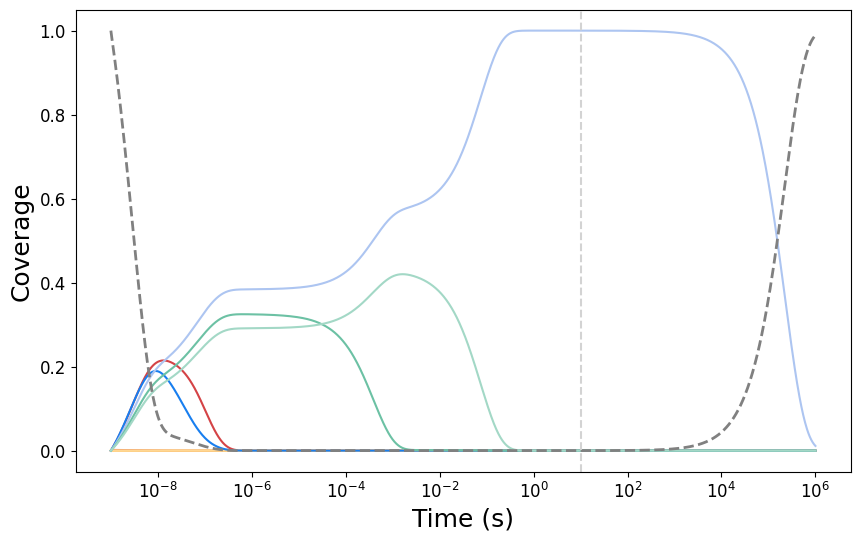

In [13]:
if __name__ == "__main__":
    main(params)